In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import time

from scipy.sparse import csr_matrix
from cvxopt.solvers import qp
from cvxopt import spmatrix, matrix, solvers

%matplotlib inline

In [2]:
class build_track:
    def __init__(self,F):
        num=200
        F1=F[0]
        F2=F[1]
        self.Center_X=np.linspace(-F1,1,num)
        self.Center_Y=np.linspace(0,0,num)
        
        self.WL=0.1
        self.WR=0.1
        
        self.Left_X=self.Center_X
        self.Left_Y=np.linspace(1,1,num)*self.WL
        
        self.Right_X=self.Center_X
        self.Right_Y=np.linspace(-1,-1,num)*self.WR
        

In [103]:
class build_path:
    def __init__(self,F,P,T):
        F1=F[0]
        F2=F[1]
        self.PX=np.array([-F1,0,F2,1])
        self.PY=P*T.WL
        self.S=np.array([0,F1,F1+F2,F1+1])
        self.WL=T.WL
        self.WR=T.WR

        self.len=F1+1
        self.Vx=0.01
        self.Np=int(np.floor(self.len/self.Vx))+1
        self.Ns=2
        self.Nc=1
        Np=self.Np
        Ns=self.Ns
        Nc=self.Nc
        
        self.ind_Y=np.arange(Np)*Ns
        self.ind_Vy=1+np.arange(Np)*Ns
        self.ind_ay=Np*Ns+np.arange(Np-1)*Nc
        
        self.X=np.linspace(-F1,1,Np)

        # parameters of constraints
        self.Q=np.array([0,1])
        self.R=np.array([100.0])
        ind=np.floor(self.S/self.Vx)
        self.ind=np.array([int(i) for i in ind])

#          # ***********build sequential state space A_qp*x=b_qp******
        self.Ac=np.array([[0,1],[0,0] ])
        self.Bc=np.array([[0],[1]])
        self.Ad=np.eye(Ns)+self.Ac
        self.Bd=self.Bc

        # dynamics model      
        A_combined1=np.zeros(((Np-1)*Ns,Np*Ns))
        A_combined2=np.zeros(((Np-1)*Ns,(Np-1)*Nc))
        
        for index in range(Np-1):
            ind1=index*Ns+np.arange(Ns)
            ind2x=index*Ns+np.arange(Ns)
            ind2I=ind2x+Ns
            ind2u=index*Nc+np.arange(Nc)
            
            A_combined1[np.ix_(ind1,ind2I)]=np.eye(Ns)
            A_combined1[np.ix_(ind1,ind2x)]=-self.Ad
            A_combined2[np.ix_(ind1,ind2u)]=-self.Bd
            
        self.A_qp=np.hstack((A_combined1,A_combined2))
        self.b_qp=np.zeros(((Np-1)*Ns))
        
        # bnd
        Gx=csr_matrix((np.ones(Np),(np.arange(Np),self.ind_Y)),
                     shape=(Np,Np*Ns+(Np-1)*Nc)).toarray()
        self.G_qp=np.vstack((Gx,-Gx))
        
#         self.G_sparse = spmatrix(G_qp[np.nonzero(G_qp)], np.nonzero(G_qp)[0].astype(int),
#                             np.nonzero(G_qp)[1].astype(int), G_qp.shape)

        hx=np.ones((Np,1))*self.WL
        self.h_qp=np.vstack((hx,hx))
#         self.h_m=matrix(h_qp)
        
        
        # Q P
        
        Q_w=np.tile(self.Q,(1,Np))
        R_w=np.tile(self.R,(1,Np-1))
        
        self.Q_qp=np.diag(np.hstack((Q_w,R_w))[0])
        self.P_qp=np.zeros((self.Q_qp.shape[0],1))
        
#         self.Q_sparse = spmatrix(Q_qp[np.nonzero(Q_qp)], np.nonzero(Q_qp)[0].astype(int), 
#                             np.nonzero(Q_qp)[1].astype(int), Q_qp.shape)
        
        
#         self.P_m=matrix(P_qp)
                             
    def generate_qp(self):
        
        Np=self.Np
        Ns=self.Ns
        Nc=self.Nc
        
        num_PY=self.PY.shape[0]

       
        Ax=csr_matrix((np.ones(num_PY),(np.arange(num_PY),self.ind*Ns)),
                     shape=(num_PY,(Np)*Ns+(Np-1)*Nc)).toarray()
            
        bx=self.PY
        

#         A_added=np.vstack((Ax,self.A_qp))
#         b_added=np.hstack((bx,self.b_qp))
    

        x=cp.Variable((Np*Ns+(Np-1)*Nc))
        cost=cp.quad_form(x,self.Q_qp)
                      
        constraints=[]
        constraints+=[self.A_qp@x==self.b_qp]
        constraints+=[Ax@x==self.PY]

#         constraints+=[A_added@x==b_added]
        
        prob=cp.Problem(cp.Minimize(cost),constraints)
        prob.solve()
        
     
        path.Y=x[self.ind_Y].value
        path.Vy=x[self.ind_Vy].value
        path.ay=x[self.ind_ay].value
        
        

In [112]:
F=np.array([0.5,0.5])
P=np.array([0.5,-0.95,0.95,-0.85])
track=build_track(F)
path=build_path(F,P,track)

times=1000
start=time.time()
for i in range(times):
#     path.generate()
    path.generate_qp()

end=time.time()

print((end-start))

113.7266628742218


0.095

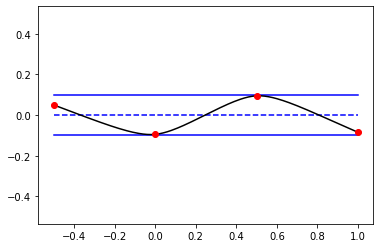

In [107]:
f=plt.figure()

plt.plot(track.Center_X,track.Center_Y,'b--')
plt.plot(track.Left_X,track.Left_Y,'b')
plt.plot(track.Right_X,track.Right_Y,'b')
plt.plot(path.X,path.Y,'k')
plt.plot(path.PX,path.PY,'ro')

plt.axis('equal')

np.max(np.abs(path.PY))

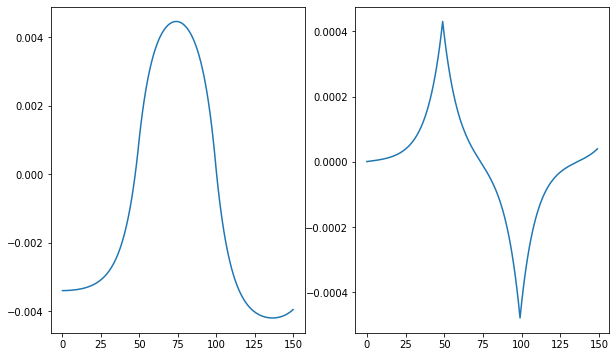

In [57]:
f2=plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(path.Vy)

plt.subplot(1,2,2)
plt.plot(path.ay)